# Dataset

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
print(path_to_zip)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
print(f'PATH is: {PATH}')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

68616192/68606236 [==============================] - 0s 0us/step
/root/.keras/datasets/cats_and_dogs.zip
PATH is: /root/.keras/datasets/cats_and_dogs_filtered
Found 2000 files belonging to 2 classes.


In [3]:
! ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [5]:
train_dataset.class_names

['cats', 'dogs']

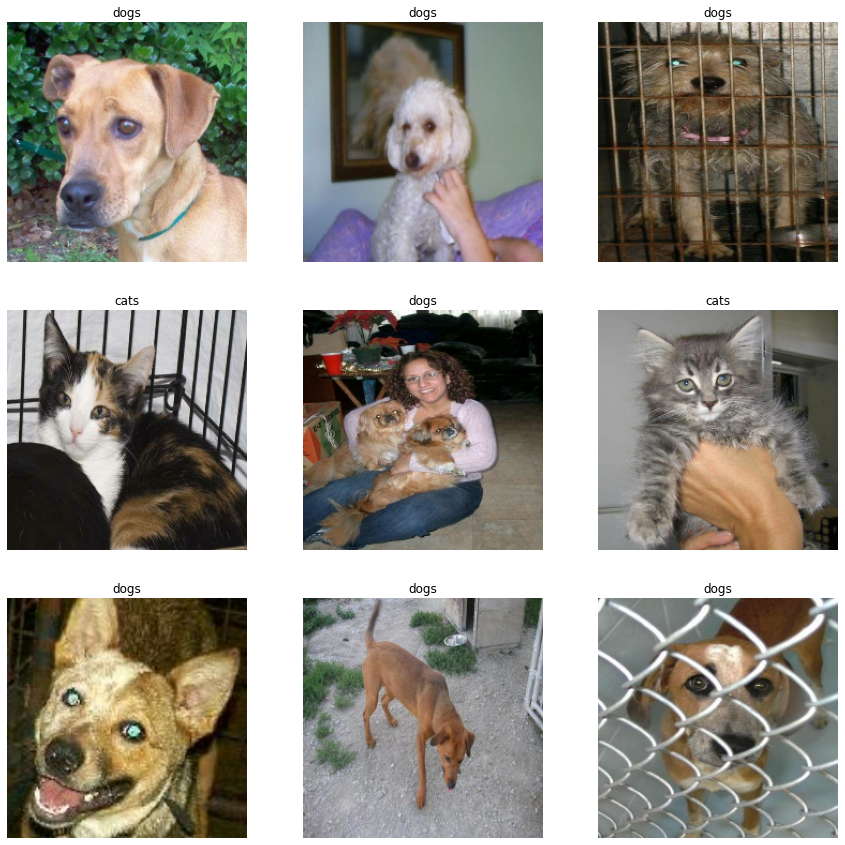

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Creating Test Set

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

In [8]:
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [9]:
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [10]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [11]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input
# rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [12]:
preprocess_input

<function keras.applications.vgg16.preprocess_input>

## VGG16 Model

In [13]:
# Create the base model from the pre-trained model VGG16
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58900480/58889256 [==============================] - 0s 0us/step


In [14]:
for layer in base_model.layers:
  print(layer.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 64), dtype=tf.float32, name=None), name='block1_conv2/Relu:0', description="created by layer 'block1_conv2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 64), dtype=tf.float32, name=None), name='block1_pool/MaxPool:0', description="created by layer 'block1_pool'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 112, 112, 128), dtype=tf.float32, name=None), name='block2_conv2/Relu:0', description="created by layer 'block2_conv2'")
KerasTensor(ty

### Convert images

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


### Freezing layers:

In [17]:
base_model.trainable = False

In [18]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


### Adding a Dense

In [20]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Creating a new model

In [21]:
def create_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  return model

In [24]:
base_learning_rate = 0.0001
initial_epochs = 10
model = create_model()

### Compiling the model

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [28]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 18s 271ms/step - loss: 3.7461 - accuracy: 0.4305 - val_loss: 2.6167 - val_accuracy: 0.4616
Epoch 2/10
63/63 [==============================] - 15s 228ms/step - loss: 2.7405 - accuracy: 0.5165 - val_loss: 1.9662 - val_accuracy: 0.5322
Epoch 3/10
63/63 [==============================] - 16s 241ms/step - loss: 2.1993 - accuracy: 0.5730 - val_loss: 1.4132 - val_accuracy: 0.6200
Epoch 4/10
63/63 [==============================] - 16s 242ms/step - loss: 1.6831 - accuracy: 0.6505 - val_loss: 1.0457 - val_accuracy: 0.6918
Epoch 5/10
63/63 [==============================] - 15s 239ms/step - loss: 1.3628 - accuracy: 0.7030 - val_loss: 0.7592 - val_accuracy: 0.7562
Epoch 6/10
63/63 [==============================] - 15s 240ms/step - loss: 1.0919 - accuracy: 0.7380 - val_loss: 0.6393 - val_accuracy: 0.7884
Epoch 7/10
63/63 [==============================] - 16s 245ms/step - loss: 0.9156 - accuracy: 0.7745 - val_loss: 0.5103 - val_accuracy: 0.8280

### Data Augmentation

In [29]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

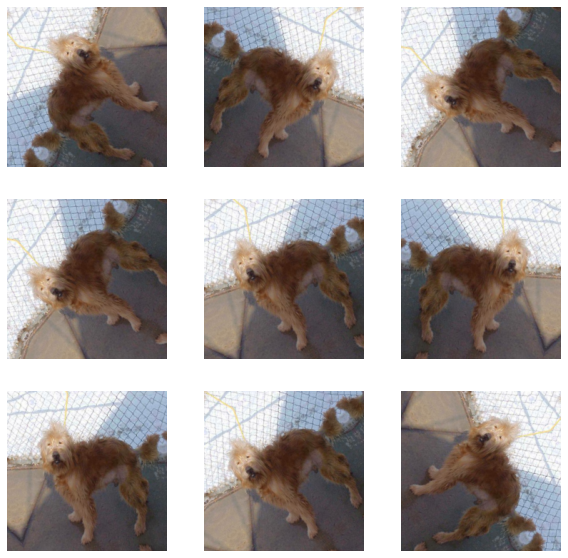

In [30]:
for images, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [31]:
def create_new_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  
  return model

In [32]:
base_learning_rate = 0.0001
new_model = create_new_model()

In [33]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
history1 = new_model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 16s 230ms/step - loss: 0.5260 - accuracy: 0.8545 - val_loss: 0.2842 - val_accuracy: 0.9022
Epoch 2/10
63/63 [==============================] - 15s 231ms/step - loss: 0.4521 - accuracy: 0.8765 - val_loss: 0.2437 - val_accuracy: 0.9208
Epoch 3/10
63/63 [==============================] - 15s 237ms/step - loss: 0.4270 - accuracy: 0.8810 - val_loss: 0.2161 - val_accuracy: 0.9344
Epoch 4/10
63/63 [==============================] - 15s 239ms/step - loss: 0.3396 - accuracy: 0.9060 - val_loss: 0.2079 - val_accuracy: 0.9332
Epoch 5/10
63/63 [==============================] - 15s 237ms/step - loss: 0.3444 - accuracy: 0.9065 - val_loss: 0.1778 - val_accuracy: 0.9443
Epoch 6/10
63/63 [==============================] - 15s 236ms/step - loss: 0.3241 - accuracy: 0.9135 - val_loss: 0.1865 - val_accuracy: 0.9394
Epoch 7/10
63/63 [==============================] - 15s 235ms/step - loss: 0.2651 - accuracy: 0.9210 - val_loss: 0.1640 - val_accuracy: 0.9431

# Fine Tuning

In [37]:
base_model.trainable = True

In [38]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [39]:
# Fine-tune from this layer onwards
fine_tune_at = 16

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [41]:
new_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [42]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                           

In [43]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_FineTune = new_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history1.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 18s 248ms/step - loss: 0.1941 - accuracy: 0.9430 - val_loss: 0.1163 - val_accuracy: 0.9604
Epoch 11/20
63/63 [==============================] - 16s 248ms/step - loss: 0.0686 - accuracy: 0.9770 - val_loss: 0.0821 - val_accuracy: 0.9715
Epoch 12/20
63/63 [==============================] - 16s 253ms/step - loss: 0.0454 - accuracy: 0.9845 - val_loss: 0.0875 - val_accuracy: 0.9678
Epoch 13/20
63/63 [==============================] - 16s 251ms/step - loss: 0.0260 - accuracy: 0.9890 - val_loss: 0.0895 - val_accuracy: 0.9740
Epoch 14/20
63/63 [==============================] - 16s 246ms/step - loss: 0.0179 - accuracy: 0.9915 - val_loss: 0.0714 - val_accuracy: 0.9802
Epoch 15/20
63/63 [==============================] - 16s 245ms/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0828 - val_accuracy: 0.9765
Epoch 16/20
63/63 [==============================] - 16s 251ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0804 - val_accuracy:

### Prediction

Predictions:
 [1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0]
Labels:
 [1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0]


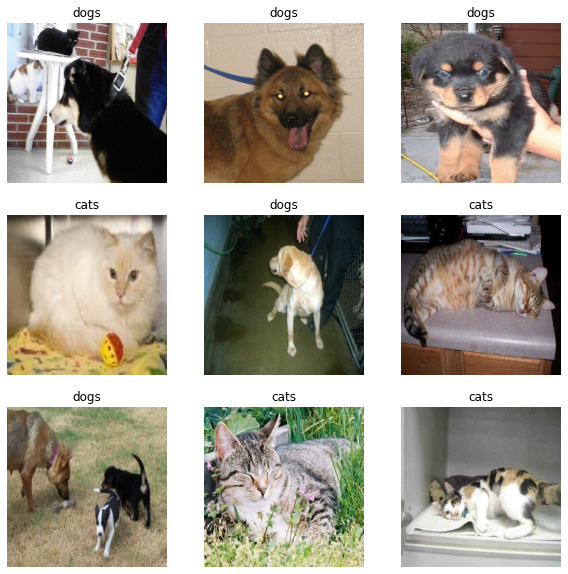

In [45]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")